# Tic-Tac-Toe AdaBoost Implementation

## Introduction

Tic-tac-toe is a two-player game where players take turns marking spaces on a three-by-three grid with their symbols (X or O). The objective is to create an unbroken line of three marks horizontally, vertically or diagonally.

In this project, we will use the tic-tac-toe dataset to demonstrate how to implement Boosting for binary classification. We will evaluate the model's performance using 5-fold cross-validation to ensure accurate results.

## Libraries

The following libraries are essential for the machine learning workflow in this project:

1. **pandas**: To read, clean, and transform data.
2. **numpy**: For numerical computations, particularly in the AdaBoost algorithm.
3. **StratifiedKFold**: To split data into folds for cross-validation.
4. **DecisionTreeClassifier**: To create and train decision stumps.
5. **accuracy_score**: To evaluate the model's performance.
6. **pyplot**: To visualize results.

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Data Preparation

First, we load the tic-tac-toe dataset and prepare it for the AdaBoost algorithm.

In [68]:
# Load tic-tac-toe board data for AdaBoost model
data = pd.read_csv('data/tttoe.csv', names=[
    'top-left-square', 'top-middle-square', 'top-right-square', 
    'middle-left-square', 'middle-middle-square', 'middle-right-square', 
    'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'Class'
])

# Encode categorical features and convert class labels to numerical values
data_encoded = pd.get_dummies(data.iloc[:, :-1]).join(data['Class'].map({'positive': 1, 'negative': -1}))
data_encoded.to_csv('data/tttoe_encoded.csv', index=False)

## Loading Data

A function to load the preprocessed data.

In [69]:
def load_data(filepath="data/tttoe_encoded.csv"):
    """Loads tic-tac-toe data from CSV."""
    return pd.read_csv(filepath)

## AdaBoost Implementation

The following function implements the AdaBoost algorithm using decision stumps.

In [70]:
def adaboost(X_train, y_train, n_estimators=300):
    """
    Implements AdaBoost with decision stumps.
    Args:
        X_train: Training data features
        y_train: Training data labels
        n_estimators: Number of boosting iterations (default is 300)
    Returns:
        stumps: List of trained decision stumps
        stump_weights: List of weights for each stump
    """
    stumps = []
    stump_weights = []
    
    n_samples = X_train.shape[0]
    sample_weights = np.ones(n_samples) / n_samples 

    for _ in range(n_estimators):
        stump = DecisionTreeClassifier(max_depth=1, random_state=42) 
        stump.fit(X_train, y_train, sample_weight=sample_weights)
        stump_pred = stump.predict(X_train)

        error = sample_weights[(stump_pred != y_train)].sum() 

        if error > 0.5:
            break

        stump_weight = 0.5 * np.log((1 - error) / error)
        sample_weights = (sample_weights * np.exp(-stump_weight * y_train * stump_pred)) / sample_weights.sum() 

        stumps.append(stump)
        stump_weights.append(stump_weight)

    return stumps, stump_weights

## Prediction Function

A function to make predictions using the trained AdaBoost ensemble.

In [71]:
def predict(X, stumps, stump_weights):
    """
    Makes predictions using the AdaBoost ensemble.
    Args:
        X: Data features for prediction
        stumps: List of trained decision stumps
        stump_weights: List of weights for each stump
    Returns:
        Array of predicted labels
    """
    return np.sign(sum(w * clf.predict(X) for clf, w in zip(stumps, stump_weights)))

## Plotting Function

A function to plot multiple metrics on the same graph.

In [72]:
def plot_metrics(metrics, labels, colors, xlabel, ylabel, title, legend_loc='best'):
    """
    Plots multiple metrics on the same graph.
    Args:
        metrics: List of metric values to plot
        labels: List of labels for each metric
        colors: List of colors for each metric line
        xlabel: Label for the x-axis
        ylabel: Label for the y-axis
        title: Title of the plot
        legend_loc: Location of the legend on the plot
    """
    plt.figure(figsize=(10, 6))
    for metric, label, color in zip(metrics, labels, colors):
        plt.plot(metric, label=label, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.grid(True)
    plt.show()

## Main Function

The main function orchestrates the entire workflow: loading data, training the model, performing cross-validation, and plotting the results.

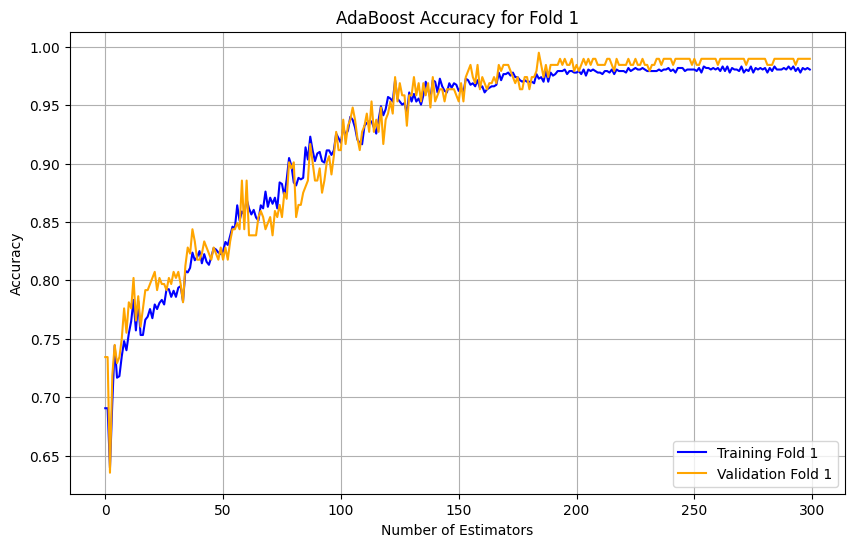

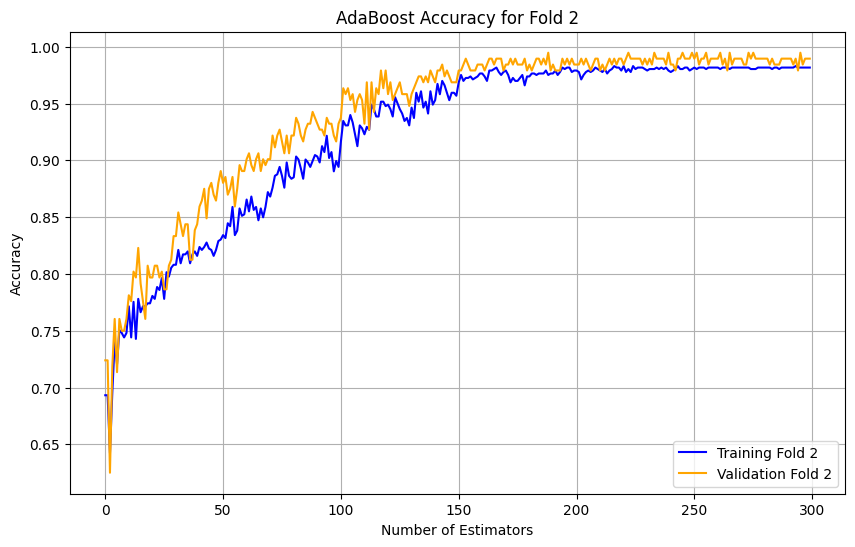

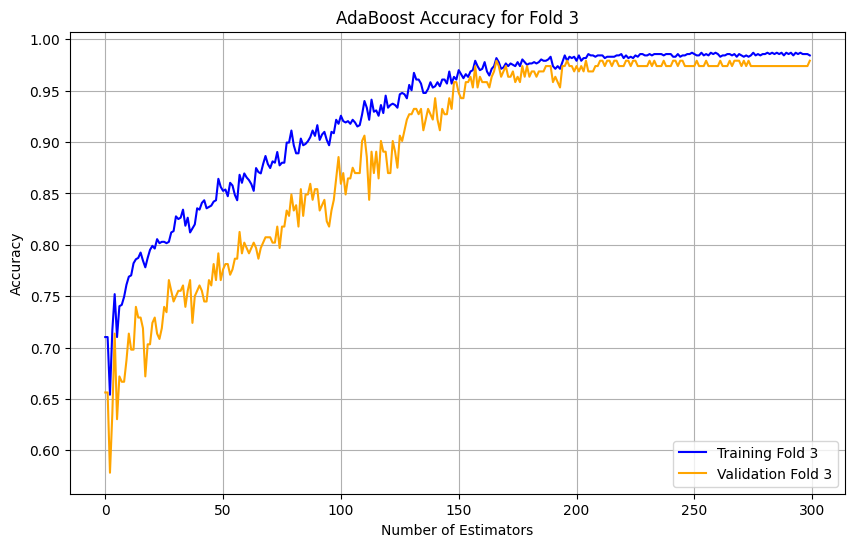

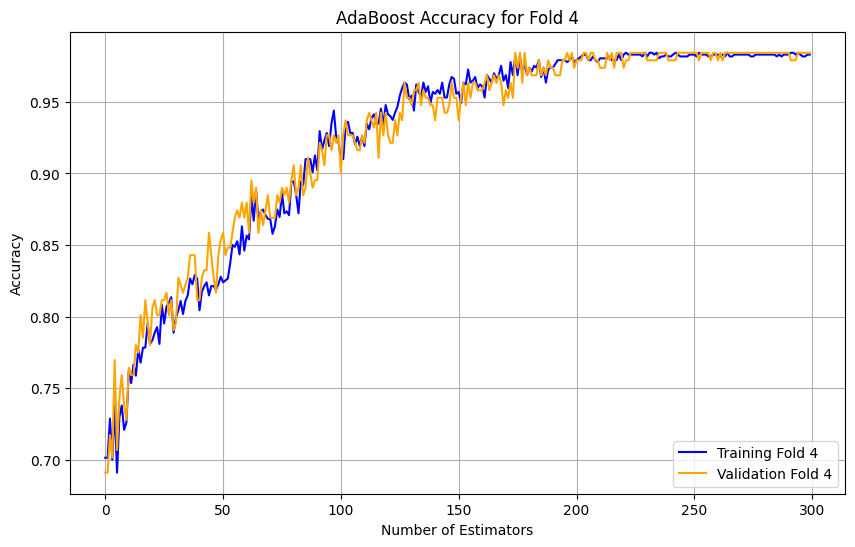

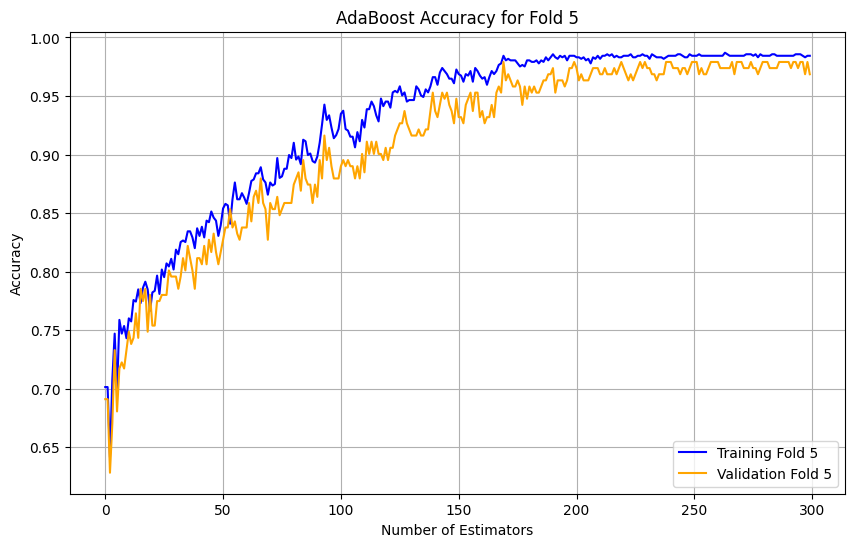

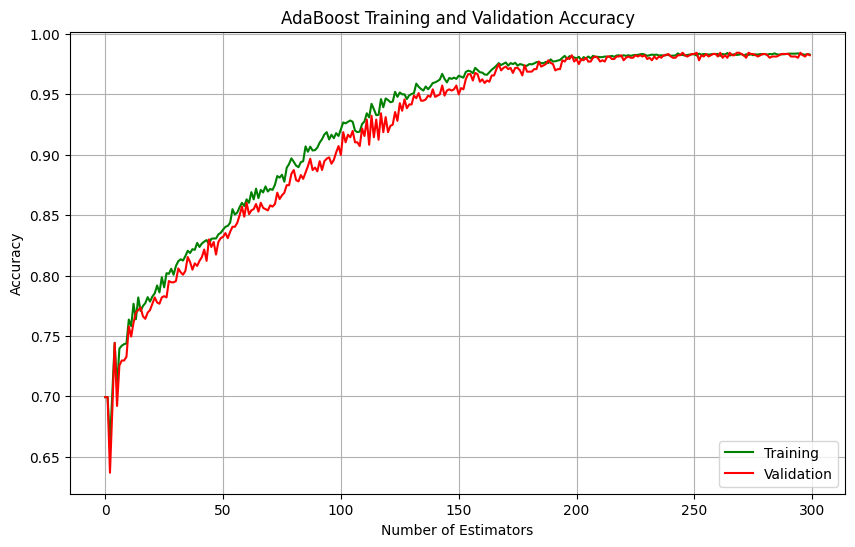

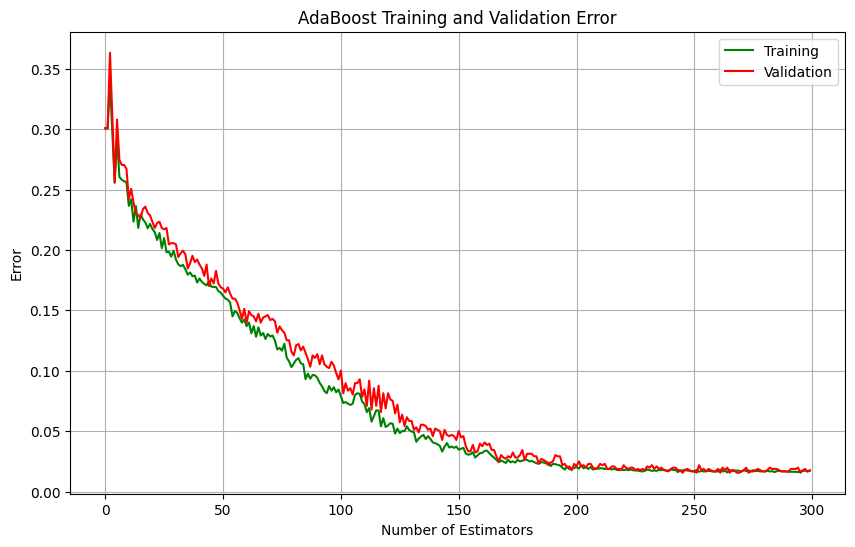

In [73]:
def main():
    data = load_data()
    X = data.iloc[:, :-1].values # Extract features
    y = data.iloc[:, -1].values # Extract labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_train_accuracies, all_val_accuracies = [], []
    all_train_errors, all_val_errors = [], []

    # Perform cross-validation
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_accuracies, val_accuracies = [], []
        train_errors, val_errors = [], []

        stumps, stump_weights = adaboost(X_train, y_train)
        
        for i in range(1, len(stumps) + 1):
            train_acc = accuracy_score(y_train, predict(X_train, stumps[:i], stump_weights[:i]))
            val_acc = accuracy_score(y_val, predict(X_val, stumps[:i], stump_weights[:i]))

            train_error = 1 - train_acc
            val_error = 1 - val_acc

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            train_errors.append(train_error)
            val_errors.append(val_error)
            
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

        all_train_errors.append(train_errors)
        all_val_errors.append(val_errors)

        plot_metrics(
            metrics=[train_accuracies, val_accuracies],
            labels=[f'Training Fold {fold_idx+1}', f'Validation Fold {fold_idx+1}'],
            colors=['blue', 'orange'],
            xlabel='Number of Estimators',
            ylabel='Accuracy',
            title=f'AdaBoost Accuracy for Fold {fold_idx+1}',
            legend_loc='lower right'
        )        
    
    mean_train_accuracies = np.mean(all_train_accuracies, axis=0)
    mean_val_accuracies = np.mean(all_val_accuracies, axis=0)

    mean_train_errors = np.mean(all_train_errors, axis=0)
    mean_val_errors = np.mean(all_val_errors, axis=0)
    
    plot_metrics(
        metrics=[mean_train_accuracies, mean_val_accuracies],
        labels=['Training', 'Validation'],
        colors=['green', 'red'],
        xlabel='Number of Estimators',
        ylabel='Accuracy',
        title='AdaBoost Training and Validation Accuracy',
        legend_loc='lower right'
    )

    plot_metrics(
        metrics=[mean_train_errors, mean_val_errors],
        labels=['Training', 'Validation'],
        colors=['green', 'red'],
        xlabel='Number of Estimators',
        ylabel='Error',
        title='AdaBoost Training and Validation Error',
        legend_loc='upper right'
    )

if __name__ == "__main__":
    main()

## Conclusion

As the number of iterations or estimators increases, the training accuracy tends to improve. This suggests that the model's ability to learn and fit the training data improves over time.

The plots reveal that after estimator 200, the model appears to assume linearity, resulting in an accuracy of approximately 98%. Conversely, the error exhibits a linear decrease over the estimators, which is also a positive outcome.
